The following notebook was adapted from Angenent-Mari et al. Their original code can be found here: https://github.com/lrsoenksen/CL_RNA_SynthBio. 

Load packages 

In [1]:
## Import Libraries
# General system libraries
import os
import gc
import cv2
import math
import h5py
import locale
import inspect
import argparse
import numpy as np
import pandas as pd
from time import time
from datetime import datetime
from subprocess import call

No protocol specified
/home/win.abernathyk/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Math & Visualization Libs
import math
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from itertools import cycle
from scipy import stats, interp
from IPython.display import Image

In [4]:
# DNA/RNA Analysis Libraries (Biopython, ViennaRNA, pysster) 
# > Biopython Lib
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
#from Bio.Alphabet import generic_rna, generic_dna, generic_protein, IUPAC
# > ViennaRNA Lib
import RNA

In [5]:
# Import Tensorflow
import tensorflow as tf

In [6]:
# Import Json
import json
import codecs

In [7]:
# Import Keras
from keras import optimizers
from keras import applications
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, load_model
from keras.models import model_from_json, load_model
from keras.layers import Activation, Conv1D, Conv2D, Reshape, BatchNormalization, Dropout, Flatten, Dense, merge, Input, Lambda, InputLayer, Convolution2D, MaxPooling1D, MaxPooling2D, ZeroPadding2D, Bidirectional
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ModelCheckpoint

In [8]:
# Import sklearn libs
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import roc_curve, auc

In [9]:
# Progress Bar
from tqdm import tqdm

In [10]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
from sys import argv
from random import randint
from string import ascii_letters
from typing import Literal, List, Tuple, Union

Training and cross-validating model based on toehold switch data

In [12]:
# Define path to load desired Toehold dataset file (.csv)
data_filename = "data/mit-data.csv"
#data_filename = "Sensor-Data.csv"
#data_path = data_folder + data_filename
data = pd.read_csv(data_filename)

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed) # Seed can be any number

In [13]:
#Creating a random column to test performance and replacing T's with U's in sequences to coorespond to ribosensor data
data['random'] = np.random.random(size=len(data))
data['seq_SwitchON_GFP'] = data['seq_SwitchON_GFP'].str.replace('T', 'U') 

In [14]:
### Data Sequence ID selection
#id_data = data['sequence_id']

### Toehold Switch dataset input/output columns for selection
input_cols = 'seq_SwitchON_GFP'
output_cols = ['ON', 'OFF', 'ON_OFF','random']
qc_levels = [1.1]
doTrain = True
loss_init = 'mae' #'logcosh', #'mse', 'mae', 'r2'
n_foldCV = 5
verbose_init = True
evaluate  = True
display_init = False

### Define data scaler (if any)
scaler_init = False
scaler = QuantileTransformer(output_distribution='uniform')

### DEFINE MODEL NAME (e.g. MLP, CNN, LSTM, etc.)
model_name = 'MLP_1D'

#Show sample of dataframe structure
data.head()

,Unnamed: 0,source_sequence,sequence_id,pre_seq,promoter,trigger,loop1,switch,loop2,stem1,...,Cbn2_off,Cbn3_off,Cbn4_off,ON,OFF,ON_OFF,QC_ON,QC_OFF,QC_ON_OFF,random
0,0,smallpox,smallpox_tile_2626,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,AACTGTTTTCCATTTTTTTTTTTTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAAAAAAAAAAAATGGAAAACAGTT,AACAGAGGAGA,AACTGT,...,1.000000,0.000000,0.0,NaN,0.333333,NaN,NaN,NaN,NaN,0.076308
1,1,smallpox,smallpox_tile_2625,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,TTAGTAACTGTTTTCCATTTTTTTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAAAAAAATGGAAAACAGTTACTAA,AACAGAGGAGA,TTAGTA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.779919
2,2,smallpox,smallpox_tile_4951,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,CTAAATTAACAATAGTAGTAATTTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAAATTACTACTATTGTTAATTTAG,AACAGAGGAGA,CTAAAT,...,0.000000,0.000000,0.0,0.068295,0.000000,0.068295,3.0,2.0,2.0,0.438409
3,3,smallpox,smallpox_tile_6492,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,TCCAAGTAGTAGTCCTACGTTATTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAATAACGTAGGACTACTACTTGGA,AACAGAGGAGA,TCCAAG,...,0.116542,0.000000,0.0,0.000000,0.038847,-0.038847,2.0,3.0,2.0,0.723465
4,4,smallpox,smallpox_tile_2624,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,ACATATTAGTAACTGTTTTCCATTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAATGGAAAACAGTTACTAATATGT,AACAGAGGAGA,ACATAT,...,0.000000,0.184934,0.0,0.080666,0.123289,-0.042624,3.0,4.0,3.0,0.977990


In [15]:
# Helper function to pass string DNA/RNA sequence to one-hot
def dna2onehot(seq):
    #get sequence into an array
    seq_array = np.array(list(seq))
    
    #integer encode the sequence
    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)
    
    #one hot the sequence
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    #reshape because that's what OneHotEncoder likes
    integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)
    onehot_encoded_seq = onehot_encoder.fit_transform(integer_encoded_seq)
    
    return onehot_encoded_seq

In [16]:
# INPUT / OUTPUT DEFINITION, PROCESSING & LOADING
#def pre_process_data (data, org_cols, input_cols, output_cols, scaler_init=False, display=True):
def pre_process_data (data, input_cols, output_cols, scaler_init=False, display=True):
    ## OUTPUT / INPUT DEFINITION, PROCESSING & LOADING
    
    #Init process bar
    tqdm.pandas() # Use `progress_apply` when `applying` one hot encoding and complementarity function to dataframe of input sequences

    df_data_input = data[input_cols].dropna()
    df_data_input = df_data_input.progress_apply(dna2onehot)
    data_input = np.array(list(df_data_input.values))
        
    # Data Output selection (QC filtered, OutColumns Only & Drop NaNs)
    df_data_output= data[output_cols]
    df_data_output = df_data_output.dropna(subset=output_cols)
    data_output = df_data_output.values.astype('float32')

    data_input = data_input[df_data_output.index.values][:][:]

    if scaler_init==True:
            data_output = scaler.fit_transform(data_output)
        
    # LOAD FULL LIST OF SEQUENCES after filtering
    data_seqs = data[input_cols][df_data_output.index.values]
        
    # Display processed data if desired
    if display==True:
        ### Show example of processed dataset
        ## Display number of retrieved sequences
        print("Number of sequences retrieved: "+str(len(data_input)))
        print()

        #Select ID to show
        toehold_id = 0 

        ## Plot Example input toehold matrix 
        print('EXAMPLE OF INPUT ONE-HOT TOEHOLD')
        onehot_encoded_seq = dna2onehot(data_seqs.iloc[toehold_id])
        print(onehot_encoded_seq.transpose())
        print()
        
        # Display input size
        print("Input Size: " + str(onehot_encoded_seq.shape))
        print()

        # Display example of Output vector
        print('EXAMPLE OF OUTPUT VECTOR')
        print(' ' + str(data_output[toehold_id]))
        print()

    return data_input, data_output

In [17]:
### Function to create Keras MLP for regression prediction
def create_mlp(width, height, regress=False):
    # Define our MLP network
    inputShape = (width, height) #DNA/RNA input sequence (one hot encoded)
    inputs = Input(shape=inputShape)
    chanDim = -1
    dropout_init = 0.2
    
    # Define dense layers
    x = inputs
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(dropout_init)(x)
    
    x = Dense(64, activation="relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(dropout_init)(x)

    x = Dense(32, activation="relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(dropout_init)(x)
    
    # Check to see if the regression node should be added
    if regress:
        x = Dense(len(output_cols), activation="linear")(x)
    else:
        x = Dense(len(output_cols), activation="sigmoid")(x)
        
    # Construct the Model
    model = Model(inputs, x) 
    
    # Return the model
    return model

In [18]:
#Definition of R2 metric for testing
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

#Definition of Custom metric as loss related to Coefficient of Determination (R2) 
#  CoD = 1 - MSE / (variance of inputs), and since this is going to be a loss we want 
#  improvement to point towards zero, so we choose mse/variance of inputs
def custom_r2_loss(y_true, y_pred): 
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return (SS_res/(SS_tot + K.epsilon()))

#Definition of Custom metric as loss related to Weigted Mean Absolute error
#  Improvement points towards zero, but penalizes loss for small values and improves it for larger values
def custom_wmae_loss(y_true, y_pred): 
    from keras import backend as K
    weightedMAE = K.abs((y_true-y_pred)*y_true) #Increase loss for large ON or OFF values -- Skews focus of distribution right
    return weightedMAE

In [19]:
#Definition of Coefficient of Determination (R2) for evaluation
def cod_r2(x,y):
    return r2_score(x,y)

In [20]:
### Define our final model architecture (layers & optimizor) and then compile it
def generate_model(trainX, testX, trainY, testY, verbose_init, evaluate=True):
    
    ## DEEP-LEARNING TRAINING PARAMETERS(e.g. verbose, patients, epoch size, batch size) to constrain process
    verbose_init = verbose_init #Zero is no keras verbose
    patience_init = 20 # Number of epochs to wait for no model improvement before early stopping a training
    epochs_init = 300 # Max number of epochs to perform (to cap training time)
    batch_size_init = 64*(1) # number of samples that will be propagated through the network at every epoch dependent on the number of GPUs
    validation_spit_init = 0.1 # Percentage of testing data to use in internal validation during training


    if verbose_init==True:
        # Callback to be used for checkpoint generation and early stopping
        callbacks_list = [EarlyStopping(monitor='val_loss', patience=patience_init, verbose = verbose_init)] # Adds Keras integration with TQDM progress bars.
    else:
        # Callback to be used for checkpoint generation and early stopping
        callbacks_list = [EarlyStopping(monitor='val_loss', patience=patience_init, verbose = False)]  
    
    ## Create Model (Change for MLP, CNN, ETC)
    # -------------------------------------------------------------------------------------------------------------------------------------
    # Define CNN model input shape
    (width, height) = np.shape(trainX[0])
    
    
    model = create_mlp(width, height, regress=False)

          
    ## Initialize the optimizer and Compile model:
    #   Custom metric is used (see above), if we use "Mean absolute percentage error" that
    #   implies that we seek to minimize the absolute percentage difference between 
    #   our *predictions* and *actual* output values. We also calculate other 
    #   valuable metrics for regression evaluation 
    opt = Adam(lr=0.001, epsilon=None, decay=1e-3/200, amsgrad=False) # epsilon=1e-1 for POISSON loss
    
    if loss_init=="r2":
        model.compile(loss=custom_r2_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine_similarity', 'acc', custom_r2_loss])
    elif loss_init =="wmae":
        model.compile(loss=custom_wmae_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine_similarity', 'acc', custom_wmae_loss])
    else:
        model.compile(loss=loss_init, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine_similarity', 'acc']) 


    model_history = model.fit(trainX, trainY, validation_split=validation_spit_init, epochs=epochs_init, batch_size=batch_size_init, callbacks=callbacks_list, verbose=verbose_init)
        
    # -------------------------------------------------------------------------------------------------------------------------------------  
        
       # Init prediction output matrix
    testX_Preds = np.zeros_like(testY) #Empty matrix for full prediction evaluation
    # Init performance metrics matrix
    test_metrics = np.zeros((trainY.shape[1],4)) #Empty matrix for model performance metrics
    #test_metrics = np.zeros((len(trainY),3))

    # GENERATE PREDICTIONS
    if testX.size > 0:
        ## Make predictions on testing data:
        print("Predicting functionality of Test Toeholds ...")
        print("")
        #Predictions in scaled space
        print(testX_Preds.shape)
        testX_Preds = model.predict(testX)
        print(testX_Preds.shape)
        
        if scaler_init == True:
            testY = scaler.inverse_transform(testY.reshape(-1, 1))
            testX_Preds = scaler.inverse_transform(testX_Preds)
        
        ## EVALUATE PERFORMANCE OF MODEL
        if evaluate==True:
            ## Plot training metrics per fold:
            plt.figure ()
            ax1 = plt.subplot(221)
            ax2 = plt.subplot(222)
            ax3 = plt.subplot(223)
            ax4 = plt.subplot(224)
            # Plot MSE metric
            ax1.set_title("Mean squared error")
            ax1.plot(model_history.history['mse'])
            # Plot MAE metric
            ax2.set_title("Mean absolute error")
            ax2.plot(model_history.history['mae'])
            # Plot MAPE metric
            ax3.set_title("Mean absolute percentage error")
            ax3.plot(model_history.history['mape'])
            # Plot CP metric
            ax4.set_title("Cosine Proximity")
            ax4.plot(model_history.history['cosine_similarity'])
            #Tight plot
            plt.tight_layout()
            

            ## Plot compiled training metrics per fold:
            plt.figure()
            plt.style.use("default")
            N = np.arange(0, len(model_history.history["loss"]))
            # Plot used Loss metric
            plt.plot(N, model_history.history["loss"], label="train_loss")
            plt.plot(N, model_history.history["val_loss"], label="test_loss")
            # Plot used Accuracy metric (applicable only if categorical model)
            plt.plot(N, model_history.history["acc"], label="train_acc")
            plt.plot(N, model_history.history["val_acc"], label="test_acc")
            # Plot MSE metric
            plt.plot(N, model_history.history["mse"], label="train_mse")
            plt.plot(N, model_history.history["val_mse"], label="test_mse")
            # Plot MAE metric
            plt.plot(N, model_history.history["mae"], label="train_mae")
            plt.plot(N, model_history.history["val_mae"], label="test_mae")
            # Plot MAPE metric
            plt.plot(N, model_history.history["mape"], label="train_mape")
            plt.plot(N, model_history.history["val_mape"], label="test_mape")
            # Plot CP metric
            plt.plot(N, model_history.history["cosine_similarity"], label="train_cp")
            plt.plot(N, model_history.history["val_cosine_similarity"], label="test_cp")
            plt.title("CNN Toehold Complementary Rep Data")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # Place a legend to the right of this smaller subplot.
                        
            
            ## COMPUTE PERFORMANCE METRICS
            # Difference between the *predicted* toehold functionality values and *actual* toehold functionality values, 
            # then compute the absolute percentage difference for diplay
            diff = testX_Preds - testY
            abstDiff = np.abs(diff)
            # Compute the mean and standard deviation of the absolute difference:
            apd_mean = np.mean(abstDiff, axis=0)
            apd_std = np.std(abstDiff, axis=0)
            apd_r2 = np.zeros_like(apd_mean)
            apd_cod_r2 = np.zeros_like(apd_mean)
            # Plot: Predicted values vs. Experimental values and get R2 value
            for index,item in enumerate(output_cols):

                # R2 (Coefficient of Determination)
                apd_r2[index] = r2(testX_Preds[:,index], testY[:,index])
                apd_cod_r2[index] = cod_r2(testY[:,index], testX_Preds[:,index])
                
                # Display Output Values
                x=np.squeeze(testX_Preds[:,index])
                y=np.squeeze(testY[:,index])
                
                # Display Output Values
                print("" + item + " Mean_absolute_error (TEST): " + str(apd_mean[index]) + " (SD: " + str(apd_std[index]) + ")" )
                print('')
                print('EXPERIMENTAL Values vs. PREDICTED values (' + item + ')' )
                print('Pearson Correlation: '+ str(stats.pearsonr(x, y)[0]))
                print('Spearman Correlation: '+ str(stats.spearmanr(x, y)[0]))
                print('R^2: '+ str(apd_r2[index]))
                print('Coefficient of Determination (R2): ' + str(apd_cod_r2[index]))
                print('')
                
                # Store model performance metrics for return   
                test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index], apd_cod_r2[index]]
                
                            
    return model, model_history, testX_Preds, test_metrics

In [21]:
### Define our crossvalidation model generator (layers, optimizor, compilation, training, reporting, etc)
def generate_crossval_model(X, Y, n_foldCV, verbose_init=True, evaluate=True):
    
    ## CROSSVALIDATION TRAINING
    # Define CV parameters
    n_foldCV = n_foldCV #Number of Crossvalidation bins
    cv_folds = list(StratifiedKFold(n_splits=n_foldCV, shuffle=True, random_state=seed).split(X,Y.argmax(1))) # Non repeating CV bins
    cv_preds = np.zeros_like(Y) #Empty matrix for full prediction evaluation
    cv_test_metrics = np.zeros((n_foldCV, Y.shape[1], 4))
    deploy_test_metrics = np.zeros((Y.shape[1],4))
    
    # Perform n-fold crossvalidated training and evaluation
    for j, (train_idx, test_idx) in enumerate(cv_folds):
        print('\nFold ',j)
        
        ## CrossValidation Strategy: 
        # We use all data for n-crossvalidation this will give us average metrics of performance in future data
        # for this all data will be devided into n bins. In every sequential fold we will use n-1 bins for training 
        # and the remaining bin for testing this split is done in such a way that all data is used for training and
        # testing at some point (sweet!). Testing points will be aggregated tenerate an average metric of performance
        # and all the datapoints will be put into a master agreement plot for visualization. 
        # A working model will be made using 75% of the data for training and 25% for further testing.
        # A deploy model will be also trained using all available data without testing
        trainX_cv = X[train_idx]
        trainY_cv = Y[train_idx]
        testX_cv = X[test_idx]
        testY_cv = Y[test_idx]
        # NOTE: Validation set is taken internally from the training set (10% of each fold), this is applied in the the model.fit function
        
        # Create & Train model each fold according to generator function
        model, model_history, testX_Preds, test_metrics = generate_model(trainX_cv, testX_cv, trainY_cv, testY_cv, verbose_init=verbose_init, evaluate=evaluate)
        
        # Record predicted values of each CV fold training to generate an ensemble reporting
        print("Predicting functionality of CV-Fold Test Toeholds & Model performance metrics ...")
        cv_preds[test_idx,:] = testX_Preds
        cv_test_metrics[j,:,:] = test_metrics
        
        ## MODEL MEMORY RELEASE
        del model_history
        del model
        for i in range(1): gc.collect()
        
        ## Free-up keras memmory to prevent leaks
        K.clear_session()
    
    #Transform back data
    if scaler_init == True:
        Y = scaler.inverse_transform(Y)
    
    # COMPUTE PERFORMANCE METRICS FOR DEPLOY MODEL
    # Difference between the *predicted* toehold functionality values and *actual* toehold functionality values, 
    # then compute the absolute percentage difference for diplay

    diff = cv_preds - Y
    abstDiff = np.abs(diff)
    # Compute the mean and standard deviation of the absolute difference:
    apd_mean = np.mean(abstDiff, axis=0)
    apd_std = np.std(abstDiff, axis=0)
    apd_r2 = np.zeros_like(apd_mean)
    apd_cod_r2 = np.zeros_like(apd_mean)

    ## EVALUATE ENSEMBLE CROSSVALIDATION PERFORMANCE OF MODEL
    if evaluate==True:
        for index,item in enumerate(output_cols): 
            # R^2 and Coefficient of Determination
            apd_r2[index] = r2(cv_preds[:,index], Y[:,index])
            apd_cod_r2[index] = cod_r2(Y[:,index], cv_preds[:,index])
            # Display Output Values
            x_tot=np.squeeze(cv_preds[:,index])
            y_tot=np.squeeze(Y[:,index])
            print('EXPERIMENTAL Values vs. PREDICTED values (' + item + ')' )
            print('Pearson Correlation: '+ str(stats.pearsonr(x_tot, y_tot)[0]))
            print('Spearman Correlation: '+ str(stats.spearmanr(x_tot, y_tot)[0]))
            print('R^2: '+ str(apd_r2[index]))
            print('Coefficient of Determination (R2): ' + str(apd_cod_r2[index]))
            print('')
            
            # Store model performance metrics for return   
            deploy_test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index], apd_cod_r2[index]]
            
    ## DEPLOYMENT MODEL TRAINING (with full dataset)
    # Partition the data into training (80%), validation (10%), testing (10%) splits 
    (trainX, testX, trainY, testY) = train_test_split(X, Y, test_size=0.1, random_state=seed)
    
    # Create model function according to generator function
    model, model_history, _ , _ = generate_model(trainX, testX, trainY, testY, verbose_init=True, evaluate=True)
                                                                                                                                               
    ## Return                                     
    return model, model_history, cv_preds, cv_test_metrics, deploy_test_metrics

In [22]:
#Definer function for full model analysis and reporting
def execute_model_analysis(model_name, data, input_cols, output_cols, qc_levels, n_foldCV, verbose_init, evaluate):
      
    #Iterate through all desired Data QC levels
    for j, qc_level in enumerate(qc_levels): 
            
        ## LOAD PREPROCESSED INPUT / OUTPUT
        data_input, data_output = pre_process_data (data, input_cols, output_cols, scaler_init=scaler_init, display=display_init)
            
        ### 3) Model Training using Manual Verification Dataset & Evaluation
        # Training with a priori training (75%) & testing (25%) split, with internal training validation from the training set (10% or the 75%)
        # This also does valuation on unseen testing data (25%), and saves base model

        # Create manual model function according to generator function, train it and display architecture
        if doTrain==True:
            # Partition the data into training (75%) and testing (25%) splits
            (trainX, testX, trainY, testY) = train_test_split(data_input, data_output, test_size=0.25, random_state=seed)
            # Generate, Train, Evaluate, Save and Display Model
            model, model_history, testX_Preds, test_metrics = generate_model(trainX, testX, trainY, testY, verbose_init=verbose_init, evaluate=evaluate)
            model.summary()
        
            ## MODEL MEMORY RELEASE
            del model_history
            del model
            for i in range(1): gc.collect()
        
            ## Free-up keras memmory to prevent leaks
            K.clear_session()

        ### 4) Model Training using k-Fold Cross Validation, Ensemble Evaluation & Full Deployment
        # The gold standard for machine learning model evaluation is k-fold cross validation
        # It provides a robust estimate of the performance of a model on unseen data. 
        # It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset. The process is repeated until all subsets are given an opportunity to be the held out validation set. 
        # The performance measure accross all models in the unseen data for each fold
        # The performance is printed for each model and it is stored
        # A final deployment model trained in all data (no testing) is provided for evaluation in future data

        # Create crossvalidated model function according to generator function, train it and display architecture
        # Generate, Train, Evaluate, Save and Display Model
        if n_foldCV>0:
            model, model_history, cv_preds, cv_test_metrics, deploy_test_metrics = generate_crossval_model(data_input, data_output, n_foldCV=n_foldCV, verbose_init=verbose_init, evaluate=evaluate)
            model.summary()
            
            ## MODEL MEMORY RELEASE
            del model_history
            del model
            for i in range(1): gc.collect()
                
            ## Free-up keras memmory to prevent leaks
            K.clear_session()
    
   

  0%|          | 0/97435 [00:00<?, ?it/s]

100%|██████████| 97435/97435 [00:27<00:00, 3606.48it/s]
2024-06-20 19:53:00.684840: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 19:53:01.029872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22083 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6


Epoch 1/300
  8/585 [..............................] - ETA: 4s - loss: 0.3588 - mse: 0.1904 - mae: 0.3588 - mape: 29492616.0000 - cosine_similarity: 0.7086 - acc: 0.2715   

2024-06-20 19:53:02.880890: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


585/585 [==============================] - 7s 9ms/step - loss: 0.2345 - mse: 0.0925 - mae: 0.2345 - mape: 12346487.0000 - cosine_similarity: 0.8292 - acc: 0.5442 - val_loss: 0.1892 - val_mse: 0.0634 - val_mae: 0.1892 - val_mape: 6323674.0000 - val_cosine_similarity: 0.8695 - val_acc: 0.6556
Epoch 2/300
585/585 [==============================] - 5s 9ms/step - loss: 0.1966 - mse: 0.0665 - mae: 0.1966 - mape: 7092287.5000 - cosine_similarity: 0.8669 - acc: 0.6462 - val_loss: 0.1852 - val_mse: 0.0607 - val_mae: 0.1852 - val_mape: 5582651.5000 - val_cosine_similarity: 0.8713 - val_acc: 0.6563
Epoch 3/300
585/585 [==============================] - 5s 9ms/step - loss: 0.1909 - mse: 0.0629 - mae: 0.1909 - mape: 6616970.5000 - cosine_similarity: 0.8725 - acc: 0.6602 - val_loss: 0.1835 - val_mse: 0.0591 - val_mae: 0.1835 - val_mape: 6559251.5000 - val_cosine_similarity: 0.8759 - val_acc: 0.6590
Epoch 4/300
585/585 [==============================] - 5s 9ms/step - loss: 0.1882 - mse: 0.0612 - mae:

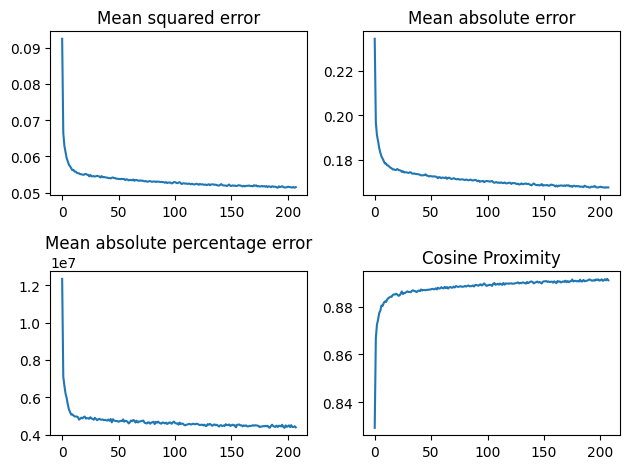

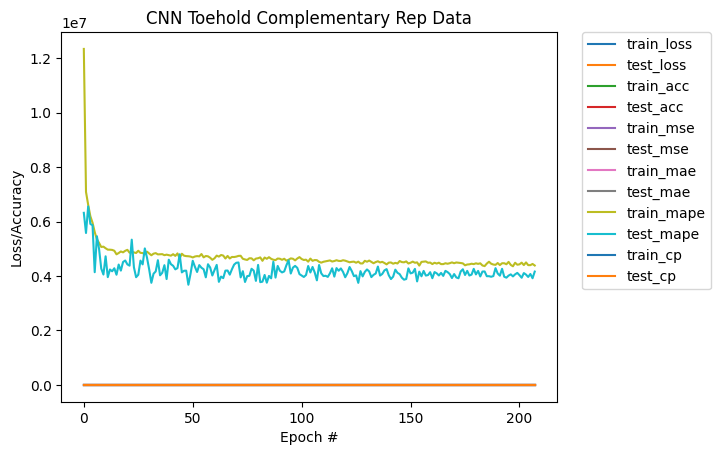

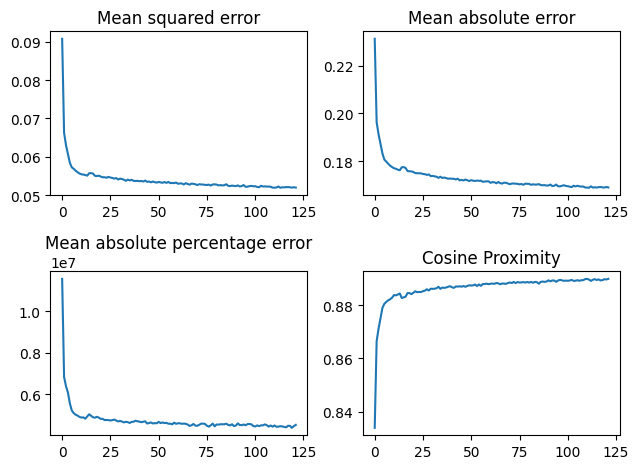

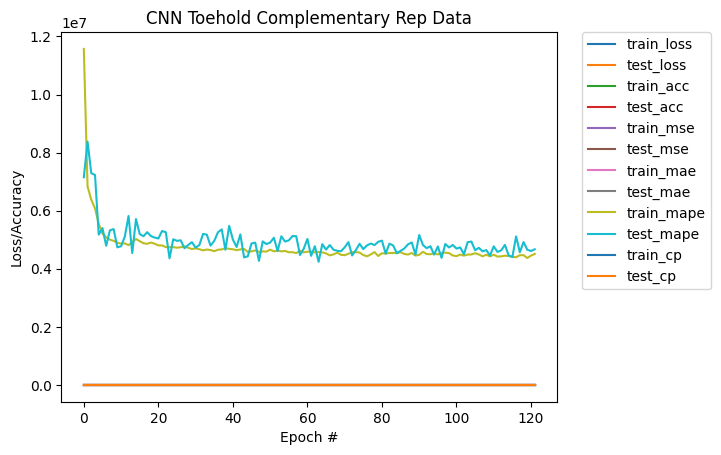

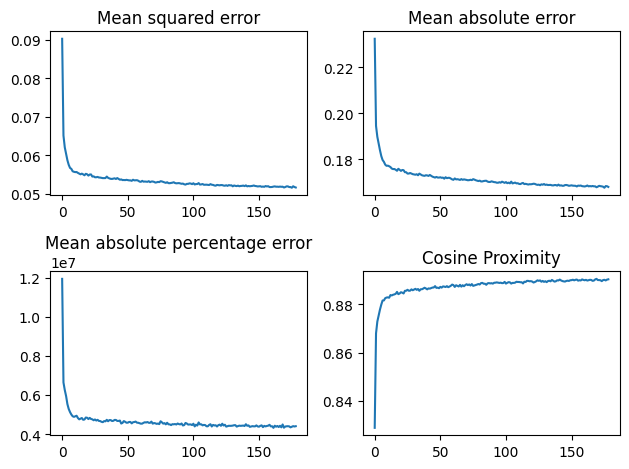

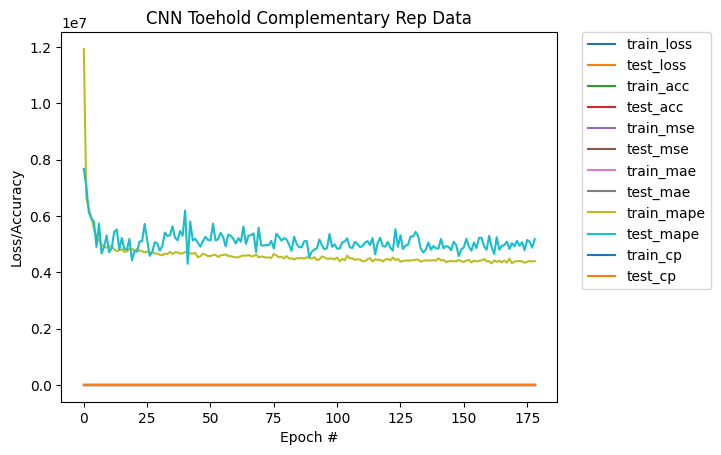

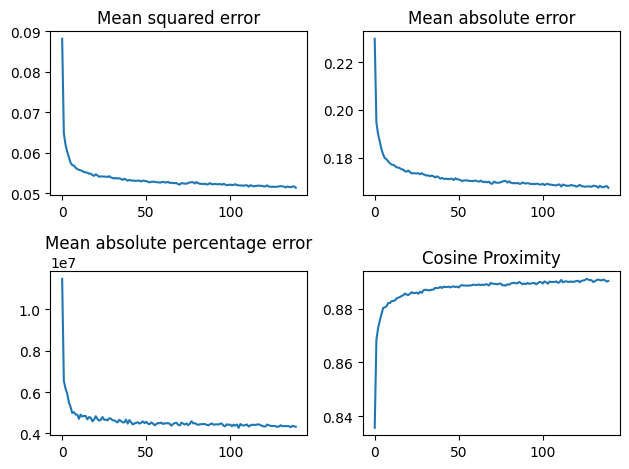

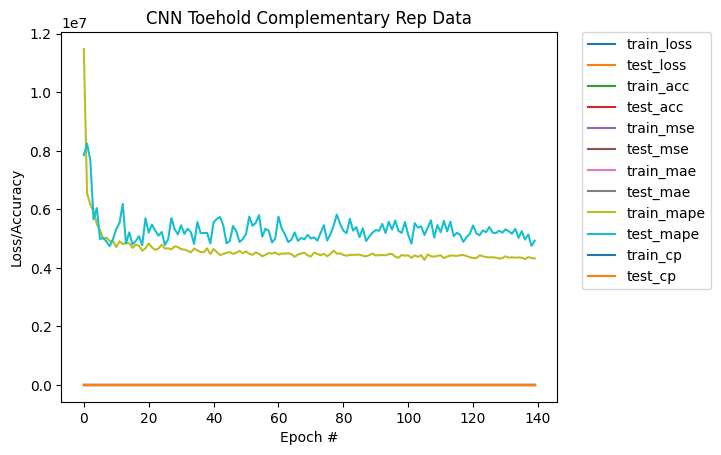

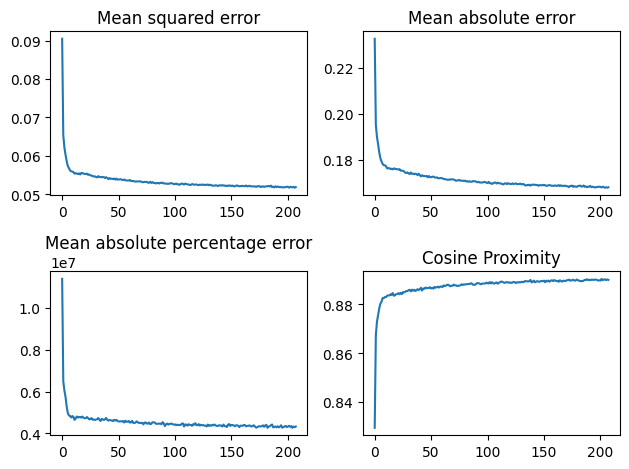

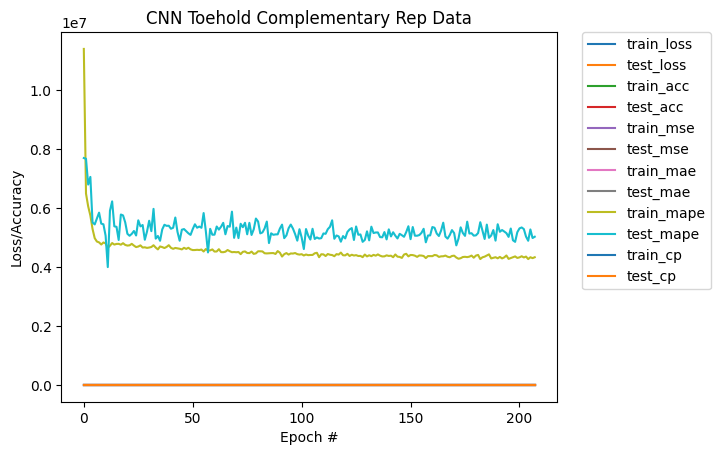

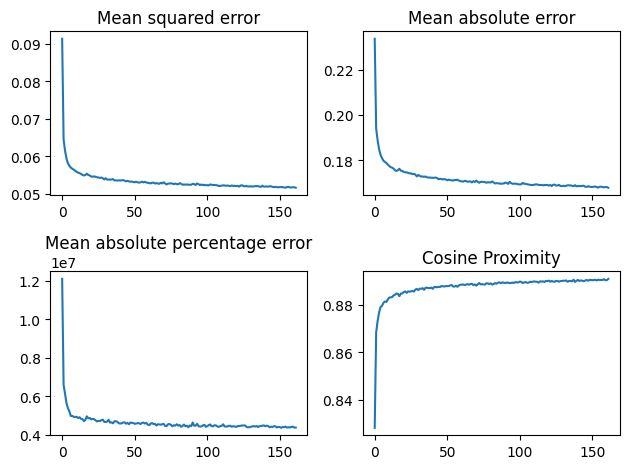

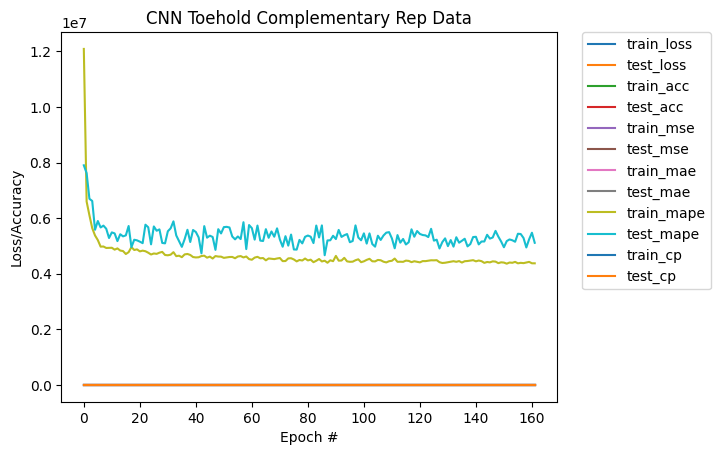

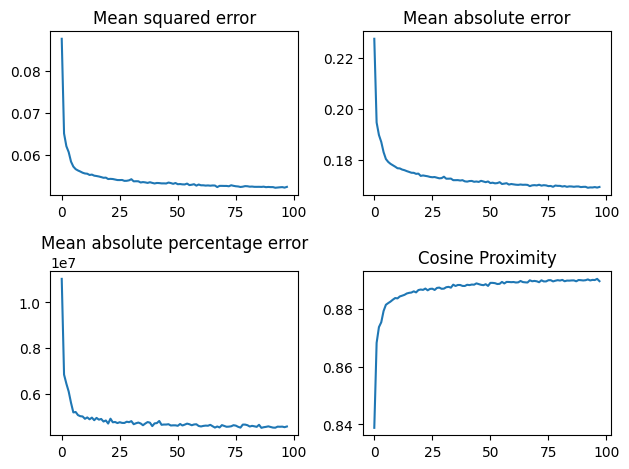

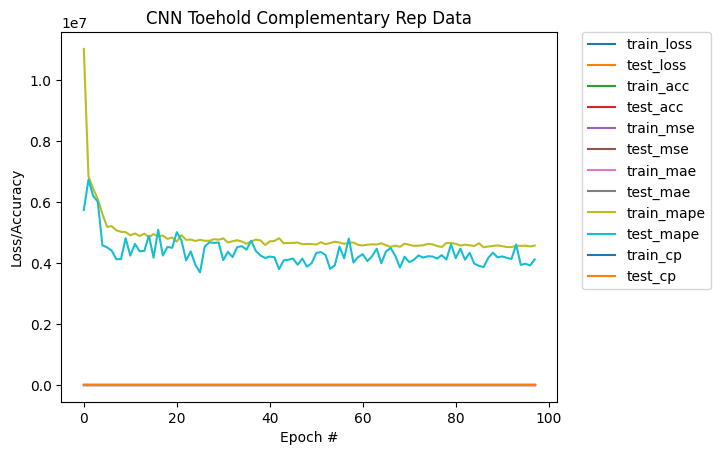

In [23]:
# RUN FULL MODEL ANALYSIS AND REPORTING model
execute_model_analysis(model_name, data, input_cols, output_cols, qc_levels, n_foldCV, verbose_init, evaluate)

Train on full toehold switch dataset and test on ribosensor data

In [24]:
# Define path to load desired Toehold dataset file (.csv)
data2_filename = "data/mit-data.csv"
data1_filename = "data/Sensor-Data-Update-9-11-23"
#data_path = data_folder + data_filename
df1 = pd.read_csv(data1_filename)
df2 = pd.read_csv(data2_filename)

In [25]:
#Normalizing columns and targets between datasets
df2['seq_SwitchON_GFP'] = df2['seq_SwitchON_GFP'].str.replace('T', 'U')
df2 = df2[df2['seq_SwitchON_GFP'].notna()]
df1['SensorSequence'] = df1['SensorSequence'].str.replace(' ', '') 
df1['seq_SwitchON_GFP'] = df1['SensorSequence']
df1['ON_OFF'] = df1['FoldIncrease']/df1['FoldIncrease'].abs().max()
df1['random'] = np.random.random(size=len(df1))
df2['random'] = np.random.random(size=len(df2))
#df1.head()

In [26]:
### Dataset input/output columns for selection
org_cols = 'seq_SwitchON_GFP'
input_cols = 'pad'
output_cols = ['ON_OFF', 'random']
qc_levels = [1.1]
doTrain = True
loss_init = 'mae' #'logcosh', #'mse', 'mae', 'r2'
n_foldCV = 10
verbose_init = True
evaluate  = True
display_init = False

### Define data scaler (if any)
scaler_init = False
scaler = QuantileTransformer(output_distribution='uniform')

### DEFINE MODEL NAME (e.g. MLP, CNN, LSTM, etc.)
model_name = 'MLP_1D'

In [27]:
def pad_sequences(sequences: 'List[List[str]]',
                  pad_type: Literal['end', 'symmetric', 'dual'],
                  *,
                  pad_str: str = 'AU',
                  pad_length: Union[int, Literal['max']] = 148) -> 'List[str]':
    '''
    Pads a list of sequences represented as a list of strings.

    Parameters:
    * sequences: list of sequences, each represented as a list of strings
    * pad_type: how the sequences should be padded
    \t* end: adds the padding to the end of the sequence
    \t* symmetric: adds the padding between 'chunks' of the sequence
    \t* dual: pads both the end and beginning equally
    * pad_str: the text to pad with
    * pad_length: 'max' or int
    \t* Max finds the length of the largest input sequence and
    \t  formats to that length

    Return: a list of formatted sequences as strings
    '''
    r_list = []

    if pad_length == 'max':
        sequences_as_str = [''.join(s) for s in sequences]
        max_len = max(sequences_as_str, key=lambda x: len(x))
        pad_length = len(max_len)

    if pad_type == 'end':
        sequences: 'List[str]' = [''.join(s) for s in sequences]
        for sequence in sequences:
            length = len(sequence)

            if length < pad_length:
                add_pad_length = pad_length - length

                additonal_padding = [pad_str] * \
                    ((add_pad_length // len(pad_str)) + 1)
                additonal_padding = ''.join(additonal_padding)
                additonal_padding = additonal_padding[:add_pad_length]

                r_list.append(sequence + additonal_padding)
            if length > pad_length:
                r_list.append(sequence[:pad_length])
            if length == pad_length:
                r_list.append(sequence)

    elif pad_type == 'dual':
        sequences: 'List[str]' = [''.join(s) for s in sequences]
        for sequence in sequences:
            length = len(sequence)

            if length < pad_length:
                add_pad_length = pad_length - length

                pad_rep = ((add_pad_length // (len(pad_str))) + 1)

                pre_reps = pad_rep // 2
                post_reps = pre_reps + 1 if pad_rep % 2 == 1 else pre_reps

                pre_str = ''.join([pad_str] * pre_reps)
                post_str = ''.join([pad_str] * post_reps)

                r_list.append((pre_str + sequence + post_str)[:pad_length])
            if length > pad_length:
                r_list.append(sequence[:pad_length])
            if length == pad_length:
                r_list.append(sequence)

    elif pad_type == 'symmetric':
        num_chunks = len(sequences)
        for sequence in sequences:
            length = len(''.join(sequence))

            if length < pad_length:
                add_pad_length = pad_length - length

                num_sub_chunk = \
                    (add_pad_length // ((num_chunks - 1) * len(pad_str)))

                symmetric_possible = num_sub_chunk > 1

                if not symmetric_possible:
                    p_seq = pad_sequences([sequence],
                                          'end',
                                          pad_str=pad_str,
                                          pad_length=pad_length)
                    p_seq = p_seq[0]

                else:
                    p_seq = [item
                             for pair in
                             zip(sequence,
                                 [pad_str] *
                                 ((num_chunks - 1) * num_sub_chunk))
                             for item in pair][:-1]

                    p_seq = ''.join(p_seq)

                    if len(p_seq) < pad_length:
                        p_seq = pad_sequences([p_seq],
                                              'end',
                                              pad_str=pad_str,
                                              pad_length=pad_length)
                        p_seq = p_seq[0]

                r_list.append(p_seq)

            if length > pad_length:
                r_list.append((''.join(sequence))[:pad_length])
            if length == pad_length:
                r_list.append(''.join(sequence))

    else:
        raise ValueError(f'Undefined padding type: {pad_type}. '
                         f'Must be one of \'end\', \'symmetric\', '
                         'or \'dual\'.')
    
    return r_list

In [28]:
# INPUT / OUTPUT DEFINITION, PROCESSING & LOADING
#def pre_process_data (data, org_cols, input_cols, output_cols, scaler_init=False, display=True):
def pre_process_data (data, input_cols, output_cols, scaler_init=False, display=True):
    ## OUTPUT / INPUT DEFINITION, PROCESSING & LOADING
    
    #Init process bar
    tqdm.pandas() # Use `progress_apply` when `applying` one hot encoding and complementarity function to dataframe of input sequences

    #Pad sequences to normalize length
    new_df = data.copy()
    pad_seq = pad_sequences(data[org_cols],pad_type='end', pad_length=190)
    new_df['pad'] = pad_seq

    df_data_input = new_df[input_cols].dropna()
    df_data_input = df_data_input.progress_apply(dna2onehot)
    data_input = np.array(list(df_data_input.values))
        
    # Data Output selection (QC filtered, OutColumns Only & Drop NaNs)
    df_data_output= data[output_cols]
    df_data_output = df_data_output.dropna(subset=output_cols)
    data_output = df_data_output.values.astype('float32')

    data_input = data_input[df_data_output.index.values][:][:]

    if scaler_init==True:
            data_output = scaler.fit_transform(data_output)
        
    # LOAD FULL LIST OF SEQUENCES after filtering
    data_seqs = new_df[input_cols][df_data_output.index.values]
    
    # Display processed data if desired
    if display==True:
        ### Show example of processed dataset
        ## Display number of retrieved sequences
        print("Number of sequences retrieved: "+str(len(data_input)))
        print()

        #Select ID to show
        toehold_id = 0 

        ## Plot Example input toehold matrix 
        print('EXAMPLE OF INPUT ONE-HOT TOEHOLD')
        onehot_encoded_seq = dna2onehot(data_seqs.iloc[toehold_id])
        print(onehot_encoded_seq.transpose())
        print()

        # Display input size
        print("Input Size: " + str(onehot_encoded_seq.shape))
        print()

        # Display example of Output vector
        print('EXAMPLE OF OUTPUT VECTOR')
        print(' ' + str(data_output[toehold_id]))
        print()

    return data_input, data_output

Epoch 1/300
779/779 [==============================] - 8s 9ms/step - loss: 0.2514 - mse: 0.0976 - mae: 0.2514 - mape: 3211231.7500 - cosine_similarity: 0.8575 - acc: 0.6685 - val_loss: 0.2244 - val_mse: 0.0757 - val_mae: 0.2244 - val_mape: 2739307.5000 - val_cosine_similarity: 0.8799 - val_acc: 0.7122
Epoch 2/300
779/779 [==============================] - 7s 9ms/step - loss: 0.2254 - mse: 0.0765 - mae: 0.2254 - mape: 2397572.2500 - cosine_similarity: 0.8790 - acc: 0.7136 - val_loss: 0.2210 - val_mse: 0.0735 - val_mae: 0.2210 - val_mape: 2677064.0000 - val_cosine_similarity: 0.8835 - val_acc: 0.7176
Epoch 3/300
779/779 [==============================] - 7s 9ms/step - loss: 0.2216 - mse: 0.0740 - mae: 0.2216 - mape: 2284324.7500 - cosine_similarity: 0.8820 - acc: 0.7202 - val_loss: 0.2199 - val_mse: 0.0730 - val_mae: 0.2199 - val_mape: 2811114.2500 - val_cosine_similarity: 0.8849 - val_acc: 0.7162
Epoch 4/300
779/779 [==============================] - 7s 9ms/step - loss: 0.2200 - mse: 0.

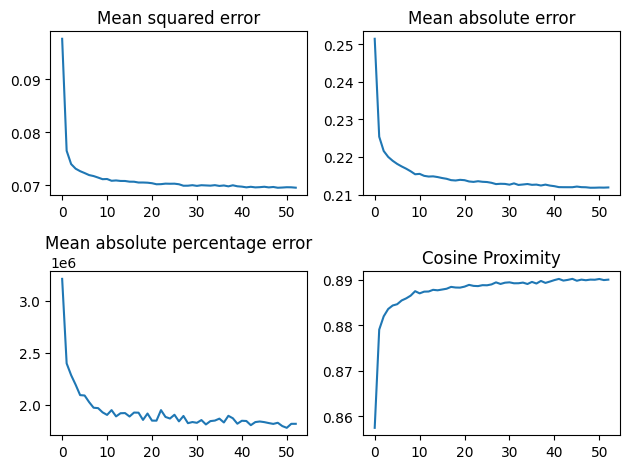

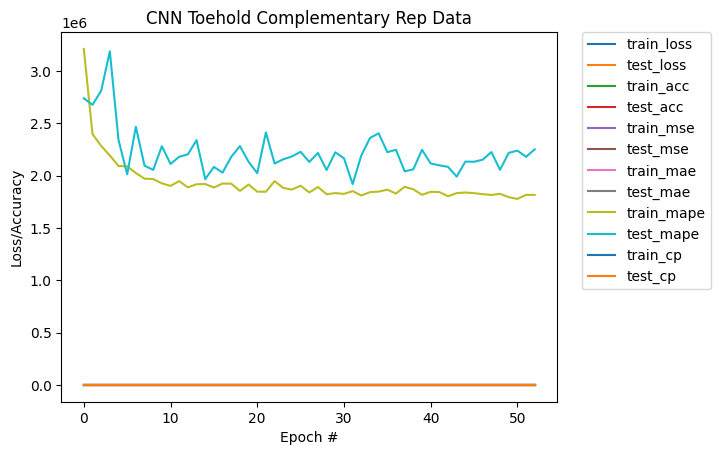

In [31]:
#Generate model that trains on toehold switch data and tests on ribosensor data
trainX, trainY = pre_process_data (df2, input_cols, output_cols, scaler_init=False, display=False)
testX, testY = pre_process_data (df1, input_cols, output_cols, scaler_init=False, display=False)
model, model_history, testX_Preds, test_metrics = generate_model(trainX, testX, trainY, testY, verbose_init, evaluate=True)